# Convergence between teaching and doing quant finance with QuantSA

Quantitative finance is a broad term, here I am referring to solving pricing problems in the capital markets space (with all their regulatory and other side effects).

I am going to explore the possibility of creating a quant library that:

 * Meets the requirements of a bank to solve pricing problems
 * Has a close link to the fundamental maths concepts so that it can be used for teaching
 
Put differently

 * It is fast and easy to use for actual products
 * You can find $(\Omega, \mathcal{F}, \mathbb{Q})$ and $\mathbb{E}^{\mathbb{Q}}\left[ H(T) \middle| \mathcal{F}_t \right]$ in the code.


To be useful on both sides of the job offer gap the library would need

 * Few and uncontroversial design decisions
 * An ability to extend and easily consume other people's extensions
 * A clear separation of problem domains:
     * Defining product cashflows
     * Simulating economies
     * Mapping products and economies into cashflow and discounted expectation simulations
     * Defining higher order measures
     * A distributable task runner (not in the public domain yet)


# Overview

 * Summary of teaching and doing objectives
 * Describe the library's main components
 * Show the overlap between describing an economy (teaching) and implementing a product (doing)
 * Implement a product and value it
 * How do models work?
 * Forward values and regression as a general tool for higher order cashflow modelling
 * A comment about early exercise
 * Final notes
 * Conclusions
 
 

# Teaching and Doing

## Teaching

When we teach we are aiming to get students to:

 * Work with SDEs
 * Understand measure changes and risk neutrality
 * See contingent claims as random variables
 * Evaluate expectations of these random variables
 * Learn supporting numerical techniques to evaluate these expectations
 


## Doing

When we do quant work we are aiming to

 * Understand a contract and business's cashflows in all states of the world
 * Select a model that realistically captures the uncertainty of those states of the world
 * Calibrate the model to a cross section of prices
 * Analyse the impacts of different modelling decisions
 * Provide the model user with an easy way to get the fair present value and sensitivities of these cashflows 
 


## Overlap

Unfortunately it seems that these two lists do not have a lot of overlap.

Sometimes we explicitly teach the cashflows for a particular contingent claim
 * usually to derive a closed form price for it
 * rather than the (messy) details of the flows (lags, physical exchanges, etc)

Doing requires delivering working software to the consumers of the models, but
 * Not every quant wants to be a software developer 
 * Not every quant needs to be a software developer
 * Someone must provide a mechanism of getting models into working software.
 
Can we teach in a way that increases the overlap?

That is what we are going to try:


# Main Library Components

 * Market Observables
 * Products (that don't know about models)
 * Models (that don't know about products)
 * a Coordinator 
 * A regression and early exercise layer
 * Higher order metrics (PV, EPE, CVA, FVA, ...)


# Setting up an Economy

We assume that we have:
 
 * a final time $T$
 * a probability space, a filtration and a measure: $(\Omega, \mathcal{F}, \mathbb{Q})$
 * stochastic processes: $\textbf{W}(t)$  (not necessarily Brownian motions notwithstanding the use of $W$)
 * a single numeraire asset $N(t)$ which is a function of $\textbf{W}(t)$, and
 * $K$ market observables are labelled $S_1(t),...S_K(t)$ which are also all functions of $\textbf{W}(t)$
   * these are not necessarily all tradable assets.  
   * could be things like forward rates or default indicators
   * just something you can see on a screen and agree on the value

We further assume that the measure $\mathbb{Q}$ is already the risk neutral one so that for any tradable asset $P$ (see later) with a cashflow only at $0<t_i<T$ we have

$$ \frac{P(t)}{N(t)} = \mathbb{E}^\mathbb{Q} \left[ \frac{P(t_i)}{N(t_i)} \middle| \mathcal{F}(t) \right] $$



## Tradable Assets/Products

We assume the cashflows on any product or portfolio 
 * take place at fixed times 
 * are calculated as functions of the $K$ market observables.  

(

This does not practically limit the types of products. E.g.
 * a cashflow when a share price hits K, is a cashflow of zero everyday when it does not. 
 
)

In general if there is a cashflow at $u_i$ it will depend on market observables at times on or before $u_i$

$$ X_i = f(S_{j_0}(v_{k_0}), S_{j_1}(v_{k_1}), ...) $$

with $(j_l, k_l)$ in some set $\mathcal{J}(u_i)$ that depends on the product and $u_i$; and $v_{k_l} \leq u_i$



## Value of Product 

The value of any product at $t_0$ is then:

$$ V(t_0) =  \mathbb{E}^\mathbb{Q} \left[ \sum_{u_i>t_0}{\frac{S_{xn}(u_i)X_i}{N(u_i)}} \right] $$
<div style="text-align: right"><b> Equation 1</b></div>

Where 
* $N(u_i)$ is the numeraire in the value currency and 
* $S_{xn}$ is that market observable that converts units of the cashflow currency into units of the numeraire currency, i.e. the exchange rate.



Any product without optionality can then be represented by 
 * the set of random variables and
 * the times at which the cashflows represented by the random variables take place

$$ P = \left\{ \left(X_1, u_1\right), ..., \left(X_M, u_M\right) \right\} $$


## Link to Doing

This all seems more like teaching quant finance rather than doing quant finance.

What do the $S$ look like and what does a $P$ look like?

The types of $S$ that currently exist in QuantSA are:

 * CurrencyPair
 * DefaultRecovery
 * DefaultTime
 * Dividend
 * FloatingIndex
 * Share

And each of these has a specific sub-type, e.g.:  
 * CurrencyPair will have a base and counter currency, 
 * DefaultTime will have a company and default type and 
 * FloatingIndex will be one of the world's named floating indices such as 3 month Jibar.

The specific sub-type of each of these has a value that is observable on a well defined screen at a well defined time.

The cashflows on a product can be written as functions of these observables.



### Example FRA
The cashflow on a South African FRA depends only on 3m Jibar, let's call that say $S_0$, observed on a single date $u_1$, a fixed rate $K$ and an accrual fraction $\Delta t$:

$$ P_{FRA} = \left\{ \left( (S_0(u_1)-K) \Delta t \frac{1}{1+ S_0(u_1) \Delta t} , u_1 \right) \right\}$$

### Example Equity Call Option
The cashflow on a cash settled equity call option with exercise date $u_1$ on a single share, say $S_1$, with strike $K$:

$$ P_{CALL} = \left\{ \left( \max(S_1(u_1)-K,0), u_1 \right) \right\}$$


# Implementing a Product

We have seen the maths of how products are defined, now let us see how to implement them in QuantSA.


## Example code FRA
```cs
Date date = new Date(2017, 08, 28);
FloatingIndex jibar = FloatingIndex.JIBAR3M;
double dt = 91.0/365.0;
double fixedRate = 0.071;
double notional = 1000000.0;
Currency currency = Currency.ZAR;

public override List<Cashflow> GetCFs()
{
    double reset = Get(jibar, date);
    double cfAmount = notional * (reset - fixedRate)*dt/(1+dt*reset);
    return new List<Cashflow>() { new Cashflow(date, cfAmount, currency) };
}
```

## Example code Call

```cs
Date exerciseDate = new Date(2017, 08, 28);
Share share = new Share("AAA", Currency.ZAR);
double strike = 100.0;

public override List<Cashflow> GetCFs()
{
    double amount = Math.Max(0, Get(share, exerciseDate) - strike);
    return new List<Cashflow>() {new Cashflow(exerciseDate, amount, share.currency) };        
}
```


## Code Explanation

We simply 
 * define the market observables, 
 * specify other contract details and 
 * implement a formula to describe the cashflow.  
 
The only apparent magic is the function call:

`Get(jibar, date)`


This product description script is common to many quant libraries available on the market.
 * similar to Portfolio Aggregation Language (PAL) described in Cesari *et al* (2010).  
     * smaller vocabulary, 
     * the syntax is straight C#, and 
     * there is no information other than what would be contained in the trade confirmation sheet.

As you can see we have "taught" exactly what a FRA and a call option are in a completely model independent way.

The next step is to look at how to value these products.

# Examples of using the Library

## Technicalities

The library is written in C#.  There are many reasons why this makes sense:

 * It is a type-safe, object-oriented language - good for building and maintaining large code bases.
 * It is easier to learn and write than C++
 * It is faster than Python or Matlab
 * It is even becoming portable
 * It plays nicely with the typical bank employee's Microsoft Windows and Office environment
 
Nevertheless Python (or Matlab) remain much more convenient for scientific computing where you are experimenting with different models and methods.

In the following we will use QuantSA from Python.

### Letting Python see the C# Library:

In [1]:
import clr # to be able to use the C# library

clr.AddReference("System.Collections")
clr.AddReference(r'C:\Dev\QuantSA\QuantSA\Valuation\bin\Debug\QuantSA.General.dll')
clr.AddReference(r'C:\Dev\QuantSA\QuantSA\Valuation\bin\Debug\QuantSA.Valuation.dll')

from System.Collections.Generic import List
from QuantSA.General import *
from QuantSA.Valuation import *
print("The library is ready to use!")

The library is ready to use!


## Making a product

In [2]:
source = """Date date = new Date(2017, 8, 28);
FloatingIndex jibar = FloatingIndex.JIBAR3M;
double dt = 91.0/365.0;
double fixedRate = 0.069;
double notional = 1000000.0;
Currency currency = Currency.ZAR;

public override List<Cashflow> GetCFs()
{
    double reset = Get(jibar, date);
    double cfAmount = notional * (reset - fixedRate)*dt/(1+dt*reset);
    return new List<Cashflow>() { new Cashflow(date, cfAmount, currency) };
}
"""
# Make a product at runtime
fra = RuntimeProduct.CreateFromString("MyFRA", source);
print("Now we have a FRA:")
print(fra)


Now we have a FRA:
MyFRA


## Setting up a model

We haven't described how to make a model or exactly what it does but the following code is fairly easy to understand:

In [3]:
# Set up the model
valueDate = Date(2016, 9, 17)
maximumDate = Date(2026, 9, 17)

dates = [Date(2016, 9, 17) , Date(2026, 9, 17)]
rates = [ 0.07, 0.07 ]
discountCurve = DatesAndRates(Currency.ZAR, valueDate, dates, rates, maximumDate)

numeraireModel = DeterminsiticCurves(discountCurve);
otherModels = List[Simulator]() # no model other than discounting for now.
coordinator = Coordinator(numeraireModel, otherModels, 1) # the magic ingredient that gets 
                                                          # models and products to work 
                                                          # together

print("A model is ready.")

A model is ready.


## Valuing the product with the model

In [4]:
# Run the valuation
portfolio = [fra]

try: 
   value = coordinator.Value(portfolio, valueDate)
except Exception as e: 
    print(e)



Required index: ZAR:JIBAR:3M is not provided by any of the simulators.
   at QuantSA.Valuation.Coordinator.AssociateFactorsWithSimulators(List`1 portfolio) in C:\Dev\QuantSA\QuantSA\Valuation\Coordinator.cs:line 654
   at QuantSA.Valuation.Coordinator.CalculateAll(Product[] portfolioIn, Date valueDate, Date[] fwdValueDates) in C:\Dev\QuantSA\QuantSA\Valuation\Coordinator.cs:line 464
   at QuantSA.Valuation.Coordinator.Value(Product[] portfolioIn, Date valueDate) in C:\Dev\QuantSA\QuantSA\Valuation\Coordinator.cs:line 569


Aha, this is good.  You can't value a FRA with a discounting model because its cashflow depends on 3 month Jibar and your model does not know anything about 3 month Jibar.

With this type of constraint (which is deeply embedded in the library):

 * You will never work under the wrong numeraire again
 * You will never use the wrong curve to forecast a rate or asset price
 * You will never incorrectly combine cashflows in different currencies
 * etc.
 
For our problem at hand we need to fix the model by setting it up to forecast some rates:

In [5]:
# add a forecast curve
forwardRates = [0.070614, 0.070614]
forecastCurve = ForecastCurve(valueDate, FloatingIndex.JIBAR3M, dates, forwardRates) # use flat 7% rates for forecasting
numeraireModel.AddRateForecast(forecastCurve) # add the forecast curve to the model

# value the product
portfolio = [fra]
value = coordinator.Value(portfolio, valueDate)
print("value is: {:.2f}".format(value))

value is: 370.12


Is the value right?

In [6]:
# check the value
import numpy as np
date = Date(2017, 8, 28)
t = (date.value - valueDate.value) / 365.0 # C# operator overloading does not work in Python
dt = 91.0 / 365.0
fixedRate = 0.069
notional = 1000000.0
fwdRate = 0.070614
refValue = (notional * (fwdRate - fixedRate) * dt / (1 + fwdRate * dt) * 
            np.exp(-t * 0.07))

print("value is: {:.2f}.  Expected {:.2f}".format(value, refValue))

value is: 370.12.  Expected 370.12


And just like that the cashflow definition can be turned into a value.


## Same Product Different Model

I have hinted that models and products are independent.

Here is a demonstration of the same FRA with a Hull White model instead of deterministic curve discounting:

In [7]:
valueDate = Date(2016, 9, 17)
flatRate = 0.07
newModel = HullWhite1F(Currency.ZAR, 0.05, 0.01, flatRate, flatRate, valueDate)
# tell HW model it is allowed to make some forecasts
newModel.AddForecast(FloatingIndex.JIBAR3M)  

newCoordinator = Coordinator(newModel, List[Simulator](), 100000)
value = newCoordinator.Value(portfolio, valueDate)
print("value with the new model is: {:.2f}".format(value))

value with the new model is: 373.65


# Implementing a Model

I won't spend much time describing how to implement models, that remains roughly the same as in the "olden days":

 * You calibrate to market data, 
 * obtain some parametrization of the stochastic processes $\textbf{W}(t)$ and functions $S_i(t)$, and then
 * simulate the $S$s.
 
The coordinating component moves the simulated values and cashflows between the products and models.

The canonical numerical scheme is Monte Carlo.  
 * For many real world pricing problems Monte Carlo is the only feasible option once 
     * sufficiently realistic dynamics and 
     * enough of the side effects are modelled.

Other numerical schemes can be implemented:
 * The first FRA model above uses the same machinery but is a curve based valuation.
     * The curve based model is fast even in this general framework:
     * In a test it valued a large portfolio of swaps averaging 0.5ms per swap.
 * In principle other numerical schemes could also be possible


 
## Expectation via Simulation

The simulation based valuation boils down to estimating:
$$ V(t_0) =  \mathbb{E}^\mathbb{Q} \left[ \sum_{u_i>t_0}{\frac{S_{xn}(u_i)X_i}{N(u_i)}} \right] $$

as 

$$ V(t_0) \approx \frac{1}{j_{max}+1}  \sum_{j=0}^{j_{max}} \left[ \sum_{u_i>t_0}{\frac{S^{(j)}_{xn}(u_i)X^{(j)}_i}{N^{(j)}(u_i)}} \right] $$


The deterministic model does one simulation


# Forward Values

In addition to the cashflows on a product that are explicitly defined by the bilateral contract, there are many other financial effects of trading a product such as:

 1. The need to fund the cashflows
 1. The capital required to be held against the position
 1. The loss in the event the counterparty defaults
 1. The need to place collateral and fund that collateral position
 1. The gain in the event that we default ourselves...
 
In general these depend on the bank's fair value of these products at future dates


## Simulating forward values

If we require the forward value at time $t_i > t_0$ we need to evaluate

$$
V(t_i) = N(t_i)\mathbb{E}^\mathbb{Q}\left[ \sum_{u_i>t_i}{\frac{S_{xn}(u_i)X_i}{N(u_i)}} \middle| \mathcal{F}(t_i) \right]
$$

 * Note that $V(t_0)$ is not random since all states of the world agree up to $t_0$ the time we are at when we fit the model and perform the valuation.
 * If $t_i>t_0$ then $V(t_i)$ is random and will be a function of the world observed up to $t_i$
 
This could be evaluated with another Monte Carlo simulation beyond $t_i$ for each state of the world observed up to $t_i$ but this is prohibitively expensive.

We rather assume that the $X$s, $S$s and $N$ are Markov and note (see Shreve [4] Def 2.3.6) that 

$$
V(t_i) = g(t_i, \textbf{W}(t_i))
$$

Longstaff and Schwartz [3] describe how to use regression to estimate this function $g$ given realizations of $\sum_{u_i>t_i}{\frac{S_{xn}(u_i)X_i}{N(u_i)}}$

In general $g$ is **exactly** that function of $\textbf{W}(t_i)$ that minimizes $\mathbb{E}^\mathbb{Q}\left[ \left(g(\textbf{W}(t_i)) - \sum_{u_i>t_i}{\frac{S_{xn}(u_i)X_i}{N(u_i)}} \right)^2 \right]$

The **approximation** comes because we are estimating it from a finite sample.

Because of the finite sample:
 * we need to apply our own regularity conditions to $g$ 
 * otherwise it would be possible to set the square error to zero for one set of paths
 * we need a $g$ that will work with out-of-sample paths.


In the QuantSA library this problem is solved by the coordinating component
 * models and products do not need to worry about it.
 * It is a separate component where development can be done that would benefit all models and products
 * The problem is well defined and is amenable to all the modern tools of datascience.
     * e.g. could train offline with cross validation to choose the best set of basis functions then online fit to all the data.

Lets look at an example of it working:

## Example of obtaining forward values

In [8]:
# Set up a swap, which has a more interesting value profile than a FRA
rate = 0.08
payFixed = True
notional = 1000000
startDate = Date(2016, 9, 17)
tenor = Tenor.Years(5)
swap = IRSwap.CreateZARSwap(rate, payFixed, notional, startDate, tenor)
print("Now we have a swap:")
print(swap)

Now we have a swap:
QuantSA.General.IRSwap


In [9]:
# Set up a stochastic model
valueDate = Date(2016, 9, 17)
a = 0.05
vol = 0.01
flatCurveRate = 0.07
hullWiteSim = HullWhite1F(Currency.ZAR, a, vol, flatCurveRate, flatCurveRate, valueDate)
hullWiteSim.AddForecast(FloatingIndex.JIBAR3M)
hwCoordinator = Coordinator(hullWiteSim, List[Simulator](), 5000)

print("A stochastic rate model is ready (Hull White).")

A stochastic rate model is ready (Hull White).


In [11]:
# make the forward dates on which the values are required
from datetime import datetime
from datetime import timedelta
step = timedelta(days=10)
pyDates = []
date = datetime(2016, 9, 17)
endDate = datetime(2021,9,17)
while date<endDate:
    date += step
    pyDates.append(date)
csDates = [Date(d.year, d.month, d.day) for d in pyDates]

In [13]:
# Get the simulated forward values and the regressors used to obtain them
hwCoordinator.SetThreadedness(True)
valuePaths = hwCoordinator.GetValuePaths([swap], valueDate, csDates)
print("Available data:")
for s in valuePaths.GetNames():
    print("   " + s)

Available data:
   fwdCashflowPVs
   regressedFwdsPVs
   regressor0


In [14]:
import sys
sys.path.insert(0, r'..\Python')
import quantsa as qsa

fwdCashflowPVs = qsa.getnumpy(valuePaths.Get("fwdCashflowPVs"))
regressor0 = qsa.getnumpy(valuePaths.Get("regressor0"))
regressedFwdsPVs = qsa.getnumpy(valuePaths.Get("regressedFwdsPVs"))



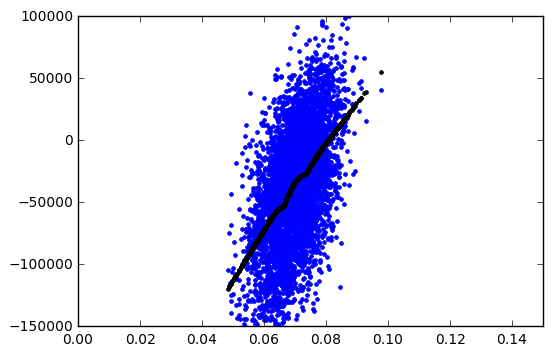

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([0, 0.15])
ax.set_ylim([-150000, 100000])
col = 17 # up to 181
plt.plot(regressor0[:,col], fwdCashflowPVs[:,col],'.')
plt.plot(regressor0[:,col], regressedFwdsPVs[:,col],'k.')

# Higher Order Measures

xVA etc.

Most "valuations" that we perform are based on:
 * Fair value simulations, 
 * Possibly some other market observables (eg. an FVA could need a funding rate)
 * A operation on these two

Example 1: The expected positive exposure depends on 
 * expected future fair values
 * no other market observables
 * a simple positive operator

Example 2: The CVA depends on:
 * expected future fair values
 * A default indicator on each path at each time
 * The product of default on a path at a time and the positive part of the future value at the same point

Again these are separate from the models and the products.

If you implement a way to estimate, say, the pricing impact of initial margin it will work with anybody else's models and or products.

## Code Example: Expected Positive Exposure

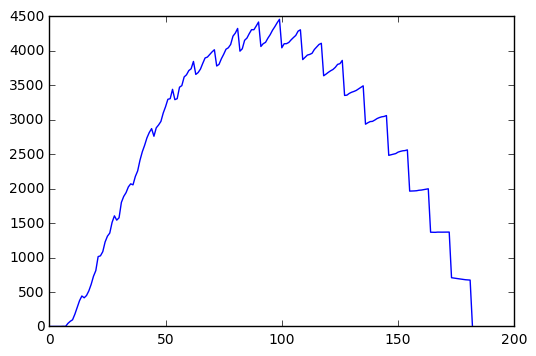

In [16]:
positive_mtm = regressedFwdsPVs
positive_mtm[positive_mtm<0] = 0
epe = np.mean(positive_mtm, 0)
plt.plot(epe)

# Early exercise

For completeness we should at least mention early exercise products.

Stopping times in quant finance are not complicated stochastic control problems.

The only exercise decisions that I have ever seen involve deciding to exercise or not at a set of dates.  

Always, one knows the cashflows as functions of states of the world both
 * when one exercises, and  
 * when one does not exercise .

The optimal stopping time for the person who owns this right is the one that chooses the alternative with the higher expected value.

This is again a general problem that does not need to be solved for each product and model.

Recall that we defined a product as:

$$ P = \left\{ \left(X_1, u_1\right), ..., \left(X_M, u_M\right) \right\} $$

Similarly we can define a product with early exercise as 

$$
O = P_{noex} \text{ and } \left\{ \left(Q_1, e_1\right), ..., \left(Q_M, e_M\right) \right\}
$$

Where 
 * the $Q_i$ are the products that will be exercised into if the optimal stopping time is equal to $e_i$, and 
 * the cashflows in $P_{noex}$ will stop at the optimal stopping time.


The extra pieces that need to be implemented on a product are then:

```cs
List<Product> GetPostExProducts();
List<Date> GetExerciseDates()
```

## Code Example: Bermudan Swaption

For a Bermudan swaption, there are no cashflows before exercise.  

Once exercise has taken place the cashflows are those of a swap.

We have a swap from above, this forms the $Q_i$ at each of the exercise dates

We simply need to set up the exercise dates:


In [17]:
# Make a Bermudan Swaption
exDates = List[Date]()
exDates.Add(Date(2017, 9, 17))
exDates.Add(Date(2018, 9, 17))
exDates.Add(Date(2019, 9, 17))
exDates.Add(Date(2020, 9, 17))
bermudan = BermudanSwaption(swap, exDates, True)

# Get the simulated forward values and the regressors used to obtain them
valuePaths = hwCoordinator.GetValuePaths([bermudan], valueDate, csDates)
fwdCashflowPVs = qsa.getnumpy(valuePaths.Get("fwdCashflowPVs"))
regressor0 = qsa.getnumpy(valuePaths.Get("regressor0"))
regressedFwdsPVs = qsa.getnumpy(valuePaths.Get("regressedFwdsPVs"))

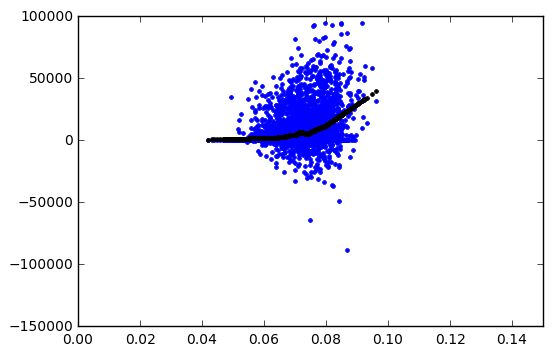

In [18]:
# Examine the values after optimal exercise rule is applied
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.set_xlim([0, 0.15])
ax.set_ylim([-150000, 100000])
col = 20 # up to 181.
plt.plot(regressor0[:,col], fwdCashflowPVs[:,col],'.')
plt.plot(regressor0[:,col], regressedFwdsPVs[:,col],'k.')



# Final Notes

Students can be taught to implement toy models that match the textbooks.

These models can then work on:
 * toy products or real products
 * toy xVAs or real xVAs

When students go to work they 
 * make the same models, in the same framework but 
     * work with more factors
     * make simulation and calibration faster
 * use these enhanced models on the bank's real portfolios and higher order metrics

The definition of product/model/measure interaction in terms only of market observables is fundamental and is unlikely to prove inadequate in the future.

This library does not change the way all courses would be taught.

For me there are also other topics in the course that I teach that do not have a place directly in the main library framework such as:

 * Measure change 
 * Getting closed form prices in HW and Black
 * How to build trees and 
 * How to derive and solve PDEs
 * etc


But, these tools and more will be required for calibrating the models in the library...

until that also just becomes another module :)

# Conclusion

With careful software management we can have a library that creates as a bridge between teaching and doing.  

The library has a separable design and a plugin framework that will meet the needs for proprietary models, special cases and user customization without damaging the clarity and teaching suitability.

I am hoping that many parts of quant finance can become like optimization: we all learn how to do it but in real life we use standard implementations.



## The Future

Finally Python offers us a great way to visualize the future of quant finance with QuantSA:

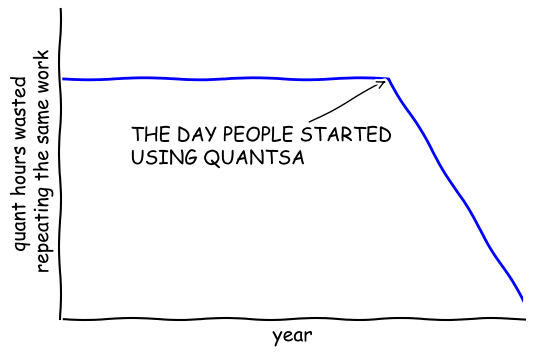

In [19]:
import numpy as np
with plt.xkcd():

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    plt.xticks([])
    plt.yticks([])
    ax.set_ylim([-30, 10])

    data = np.ones(100)
    data[70:] -= np.arange(30)

    plt.annotate(
        'THE DAY PEOPLE STARTED\nUSING QUANTSA',
        xy=(70, 0.9), arrowprops=dict(arrowstyle='->'), xytext=(15, -10))

    plt.plot(data)

    plt.xlabel('year')
    plt.ylabel('quant hours wasted \n repeating the same work')
    plt.show()

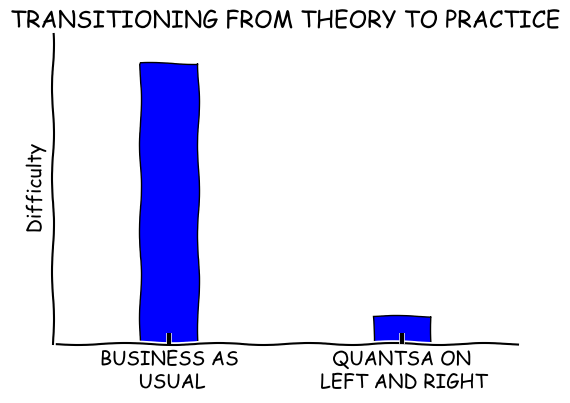

In [20]:
with plt.xkcd():
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.bar([-0.125, 1.0-0.125], [100, 10], 0.25)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([0, 1])
    ax.set_xlim([-0.5, 1.5])
    ax.set_ylim([0, 110])
    ax.set_xticklabels(['BUSINESS AS\n USUAL', 'QUANTSA ON \n LEFT AND RIGHT'])
    plt.yticks([])
    plt.ylabel('Difficulty')
    plt.title("TRANSITIONING FROM THEORY TO PRACTICE")

    plt.show()

# References

[1] Serguei Issakov Alexandre Antonov and Serguei Mechkov. Backward induction for future values.
*Risk*, pages 92-97, 2015.

[2] G. Cesari, J. Aquilina, and N. Charpillon. *Modelling, Pricing, and Hedging Counterparty Credit
Exposure*. Springer, 2010.

[3] Francis A. Longstaff and Eduardo S. Schwartz. Valuing american options by simulation: A
simple least-squares approach. *Review of Financial Studies*, pages 113-147, 2001.

[4] S.E. Shreve. *Stochastic Calculus for Finance II: Continuous-Time Models.* Number v. 11 in
Springer Finance Textbooks. Springer, 2004.

# Resources

<http://www.quantsa.org/>

https://github.com/JamesLTaylor/QuantSA